# SoCal EVCS Network analysis

**Author: [Jarvis Yuan](www.linkedin.com/in/jarvis-yuan)**

In [ ]:
! pip install pd

In [435]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from scipy import stats
import haversine as hs
from shapely import geometry
import pyproj
import mapclassify
import geoplot.crs as gcrs
import geoplot
import collections
from haversine import haversine, Unit
import contextily as cx
import warnings
import mapclassify as mc

warnings.filterwarnings('ignore')

In [5]:
os.chdir('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork')
os.getcwd()

'/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork'

# Extract Roadway Network with osmnx

## Extract from custom bonding box on entire SoCal region

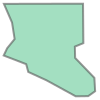

In [428]:
bbox = [[-117.780360058,33.3834315757], [-118.2254136354,33.6270330842],
        [-118.4992028028,33.7524390501], [-118.5306597501,33.8702505871],
        [-118.8714719564,34.0016338706], [-118.8188845665,34.1118843391],
        [-118.7057865411,34.2508358116], [-118.7449038774,34.5004071652],
        [-118.8681996614,34.7840823241], [-117.669498995,34.7864790651],
        [-117.6645851881,34.1891744165], [-117.7930683643,34.1363620016],
        [-117.7893132717,33.9653145708], [-117.4975264818,33.6624559519],
        [-117.4861431867,33.4605582062], [-117.5918570906,33.385975796],
        [-117.780360058,33.3834315757]]

bbox_points = []
for p in bbox:
    bbox_points += [geometry.Point(p[0], p[1])]

poly = geometry.Polygon([[p.x, p.y] for p in bbox_points])
poly

In [372]:
# only project the graph after adding EVCS nodes

cf = '["highway"~"motorway|primary"]'
G_og = ox.graph_from_polygon(poly, custom_filter=cf, simplify=False)
G_og = ox.utils_graph.remove_isolated_nodes(G_og)
G_og = ox.simplify_graph(G_og)

## Condolidate network and projection

In [373]:
# projection for consistency
G = ox.project_graph(G_og, to_crs='EPSG:3857')

# consolidate intersections by merging nearby nodes with tolerance of projected unit, m
G = ox.consolidate_intersections(G, tolerance=150, rebuild_graph=True, dead_ends=False)

In [374]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
print("Coordinate system:", edges.crs)

Coordinate system: EPSG:3857


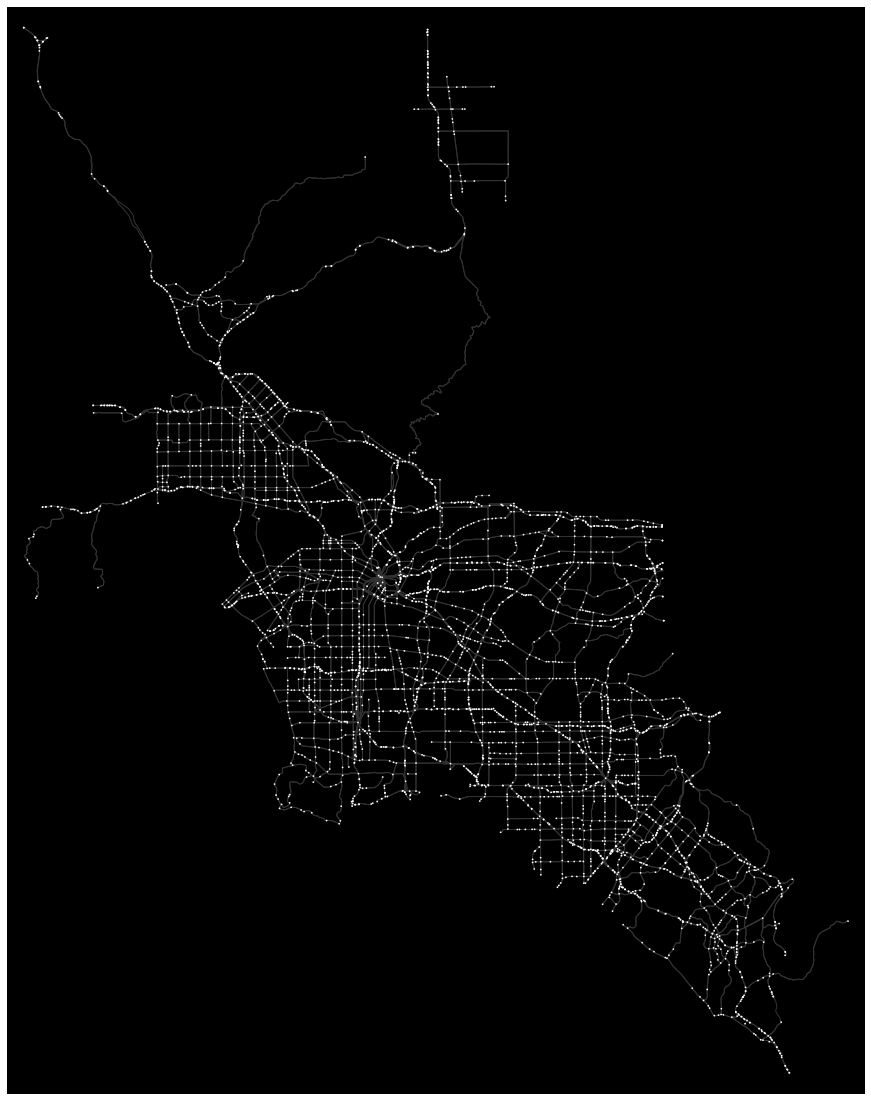

In [375]:
fig, ax = ox.plot_graph(
    G, 
    bgcolor='black', 
    edge_color="#333333", node_color="white", node_size=3, 
    figsize=(20, 20)
)

---

Simple network edge centrality analysis experiment

---

# EVCS data

## Loading dataset

In [376]:
colns = ['ID', 'AddressInfo_Postcode', 'AddressInfo_Latitude', 'AddressInfo_Longitude', 
         'Connections_0_LevelID', 'DateCreated']
chargers = pd.read_csv('data/charging_stations_la.csv')[colns]
chargers = gpd.GeoDataFrame(chargers, geometry=gpd.points_from_xy(chargers.AddressInfo_Longitude, 
                                                                  chargers.AddressInfo_Latitude))
chargers.dropna(inplace=True)
chargers.reset_index(drop=True, inplace=True)
chargers.drop(['AddressInfo_Latitude', 'AddressInfo_Longitude'], axis=1, inplace=True)
chargers['Connections_0_LevelID'] = chargers['Connections_0_LevelID'].astype(int)
chargers.head()

,ID,AddressInfo_Postcode,Connections_0_LevelID,DateCreated,geometry
0,139561,90241,2,2019-12-24T09:11:00Z,POINT (-118.13679 33.95245)
1,4841,90241,2,2011-07-04T18:02:00Z,POINT (-118.14548 33.94630)
2,75793,90723,2,2016-12-23T01:25:00Z,POINT (-118.13371 33.94175)
3,121989,90241,2,2019-04-06T05:02:00Z,POINT (-118.15117 33.94730)
4,139551,90241,2,2019-12-24T09:11:00Z,POINT (-118.12922 33.94080)


In [377]:
chargers.dtypes

ID                          int64
AddressInfo_Postcode       object
Connections_0_LevelID       int64
DateCreated                object
geometry                 geometry
dtype: object

## Filtering the stations within custom bbox and projecting

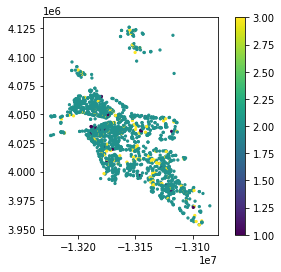

In [379]:
chargers_socal = chargers.loc[chargers.within(poly)]
chargers_socal.reset_index(drop=True, inplace=True)

# same projection with the street network
chargers_socal = chargers_socal.set_crs(epsg=4326)
chargers_socal = chargers_socal.to_crs(G.graph['crs'])

chargers_socal.plot(markersize = 5, column = 'Connections_0_LevelID', legend = True);

projection, both graph and charger table should have the same crs

In [380]:
G.graph['crs']

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [381]:
chargers_socal.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## EVCS KDE plot

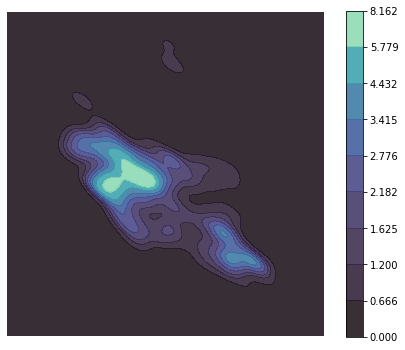

In [389]:
# kde plot, showing density of chargers in the study area and aggregate level sets
geoplot.kdeplot(
    chargers_socal.to_crs(epsg=4326), 
    cmap='mako', alpha=0.85, shade=True, shade_lowest=True, 
    cbar=True, levels=10, bw_adjust=0.7);

## Finding all nearest nodes to the EV chargers

In [383]:
nearest_node_ids = []

for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].y, row['geometry'].x)
    nearest_node_ids.append(ox.get_nearest_node(G, ev_node, method = 'euclidean')) # lat, lon

In [384]:
nearest_node_ids[0:10]

[1309, 1278, 1260, 1294, 1316, 1295, 1295, 1316, 1266, 1295]

## Adding EV charging stations as nodes to the street network

In [385]:
# all nodes id in the road network
node_ids = list(G.nodes)
G.nodes[node_ids[20]]

{'osmid_original': 780419146,
 'y': 3960921.305973796,
 'x': -13097968.172201902,
 'ref': '81',
 'highway': 'motorway_junction',
 'street_count': 3,
 'lon': -117.66105,
 'lat': 33.4929664}

In [386]:
type(node_ids[0]), type(chargers_socal.loc[0]['ID'])

(int, numpy.int64)

- checking the number of duplidate node ids with EV charger IDs

In [387]:
num_dup_ids = 0
for index, row in chargers_socal.iterrows():
    if row['ID'] in node_ids:
        num_dup_ids += 1
        print(row['ID'])
num_dup_ids # found duplidates

2501
2609
2407
2389
2443
2442
2441
2608
2562
2591
2539
2573
2530
2490
2576
2566
2491
2554
2598
2925
2499
2537
2544
2543
2509


25

### Define unique EVCS id

In [391]:
evcs_id = []
for index, row in chargers_socal.iterrows():
    evcs_id += ['evcs-' + str(row['ID'])]

- adding EV chargers as nodes 
- appended 'ev_charger' node property for later filtering use

In [393]:
for index, row in chargers_socal.iterrows():
    G.add_node(evcs_id[index], y=row['geometry'].y, x=row['geometry'].x, ev_charger='yes')

In [395]:
# test for a known EV charger node
G.nodes['evcs-139561']

{'y': 4022419.1561405594, 'x': -13150927.752029857, 'ev_charger': 'yes'}

## Adding edges from EVCS nodes to its nearest neighbor node

the automatically uses edge lengths as the weight when calculating betweenness centrality. For any further customization, one can just call `nx.betweenness_centrality(G)` directly on your OSMnx graph object, and parameterize it as desired.

In [396]:
# the default street network is not weighted, ignore when adding edges
nx.is_weighted(G) 

False

In [397]:
# sample edge data of the network
G.get_edge_data(14840398, 1846221722) # length in meters

In [398]:
# use the parsed array of nearest node ids in the street network to connect to as new edges. 
for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].x, row['geometry'].y)
    ev_node_id = evcs_id[index]    #row['ID']
    
    node_id = nearest_node_ids[index]
    nx_node = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
    
    length = hs.haversine(ev_node, nx_node, unit=Unit.METERS)
    
    G.add_edge(ev_node_id, node_id, key=ev_node_id, length=length) # use EV charger ID as edge key

---

## Plot the appended network

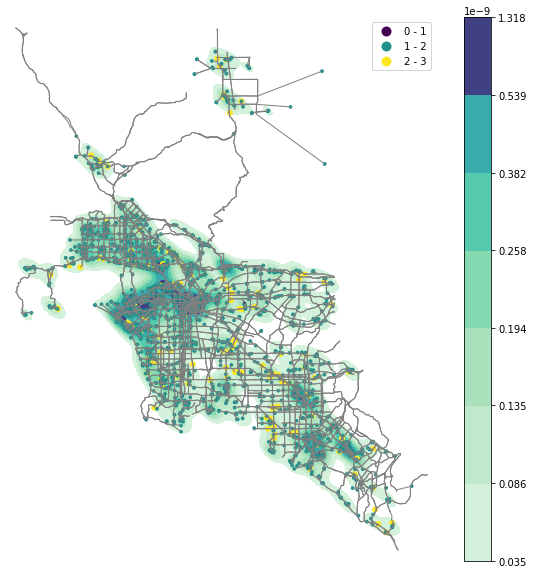

In [436]:
fig, ax = plt.subplots(figsize=(10, 10))

#cax = fig.add_axes([0.2, 0.15, 0.02, 0.3])
#sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=1, vmax=3))
#cbr = fig.colorbar(sm, cax=cax)
#cbr.ax.tick_params(labelsize=10)

scheme = mc.UserDefined(chargers_socal['Connections_0_LevelID'], bins=[1, 2, 3])

geoplot.kdeplot(
    chargers_socal['geometry'], 
    cmap='mako_r', shade=True, 
    shade_lowest=False, cbar=True, levels=8, 
    bw_adjust=0.3, 
    ax=ax
);

geoplot.pointplot(
    chargers_socal,
    hue='Connections_0_LevelID', scheme=scheme,
    legend=True,
    scale='Connections_0_LevelID',
    limits=(0.5, 5),
    ax=ax
);


#chargers_socal.plot(ax=ax, markersize = 20, column = 'Connections_0_LevelID', legend = False, alpha=1, cmap='plasma');
ox.plot_graph(G, ax=ax, edge_color="grey", node_size=0);

## Network basic stats

In [409]:
nodes_proj = ox.graph_to_gdfs(G, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('network area = ', graph_area_m, 'm^2')
ox.basic_stats(G, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
# reduced the network complexity by a factor of ~10 after consolidation

network area =  18624281838.374893 m^2


{'n': 6580,
 'm': 11426,
 'k_avg': 3.4729483282674773,
 'intersection_count': 2152,
 'streets_per_node_avg': 0.9996960486322188,
 'streets_per_node_counts': {0: 0, 1: 0, 2: 29, 3: 1989, 4: 120, 5: 11, 6: 3},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.0,
  2: 0.004407294832826748,
  3: 0.30227963525835866,
  4: 0.0182370820668693,
  5: 0.0016717325227963526,
  6: 0.0004559270516717325},
 'edge_length_total': 25784876270.780647,
 'edge_length_avg': 2256684.427689537,
 'street_length_total': 25782752128.03422,
 'street_length_avg': 2521047.436006084,
 'street_segments_count': 10227,
 'node_density_km': 0.35330221358882496,
 'intersection_density_km': 0.11554807958102603,
 'edge_density_km': 1384476.271060907,
 'street_density_km': 1384362.2187304678,
 'circuity_avg': 1898.8681753133178,
 'self_loop_proportion': 0.00017503938386136881,
 'clean_intersection_count': 6031,
 'clean_intersection_density_km': 0.3238245668927361}

In [410]:
# write to save appended network, run only once
#os.getcwd()
#ox.save_graphml(G, 'data/socal_street_network_consolidated_w_chargers.graphml')

## Add a basemap

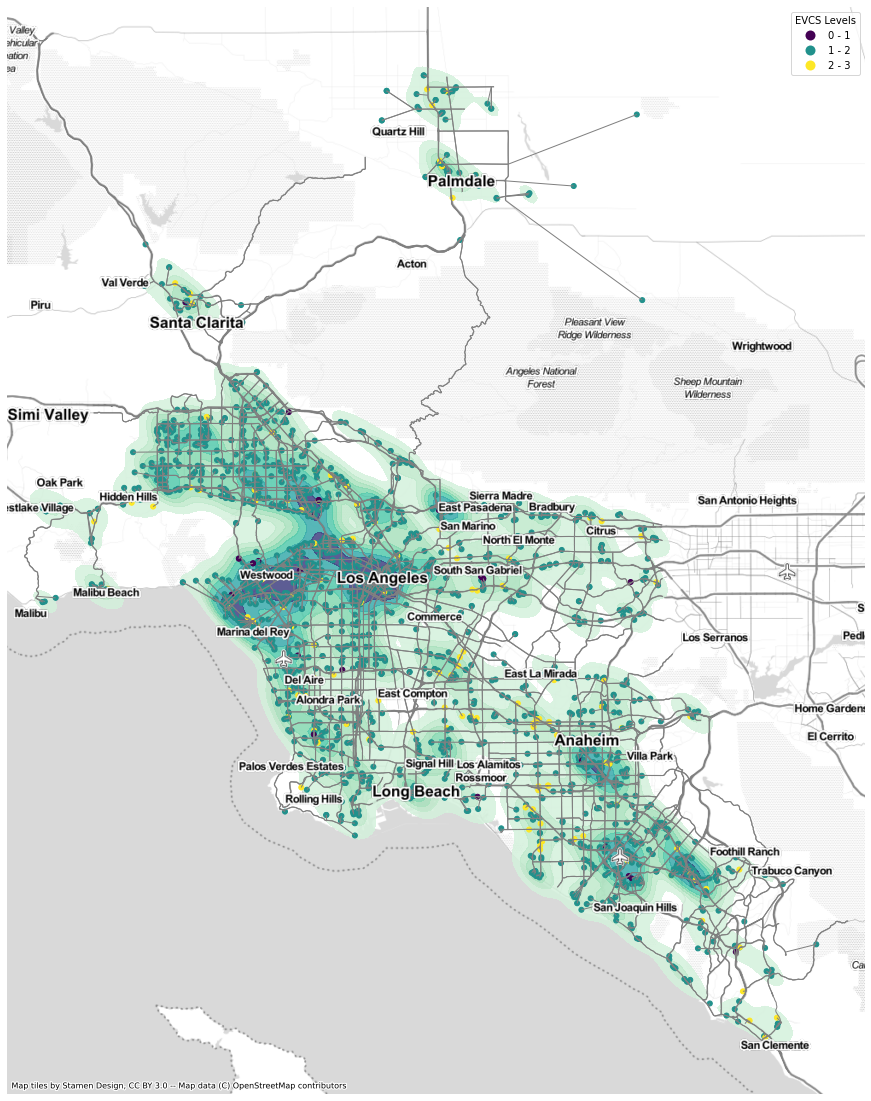

In [443]:
fig, ax = plt.subplots(figsize=(20, 20))

scheme = mc.UserDefined(chargers_socal_wm['Connections_0_LevelID'], bins=[1, 2, 3])

chargers_socal_wm.plot(ax=ax, markersize=0, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLite, zorder=0);
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels, zorder=1);

x, y = poly.exterior.xy
ax.plot(x, y, zorder=10)

geoplot.kdeplot(
    chargers_socal_wm['geometry'], 
    cmap='mako_r', alpha=0.85, shade=True, 
    shade_lowest=False, cbar=False, levels=8, 
    bw_adjust=0.3, 
    ax=ax, zorder=1
);

geoplot.pointplot(
    chargers_socal_wm,
    hue='Connections_0_LevelID', scheme=scheme,
    legend=True,
    ax=ax,
    legend_kwargs={'title': 'EVCS Levels'}
);


ox.plot_graph(G, ax=ax, edge_color="grey", node_size=0);
fig.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork/plot/SoCalEVCS_kde_basemap.png', dpi=300)

# Initial Analysis of the network

In [197]:
# average shortest path length
nx.average_shortest_path_length(G)

KeyboardInterrupt: 

node degree historgam 

/Users/jarvis/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


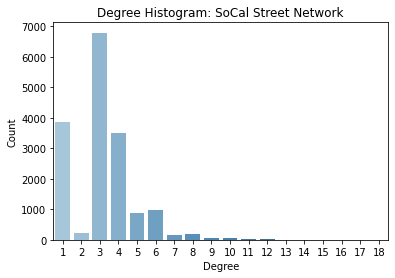

In [37]:
# creating degree histogram

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

ax = sns.barplot(list(deg), list(cnt), palette="Blues_d")

plt.title("Degree Histogram: SoCal Street Network")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

shortest path distribution using physical length as weights

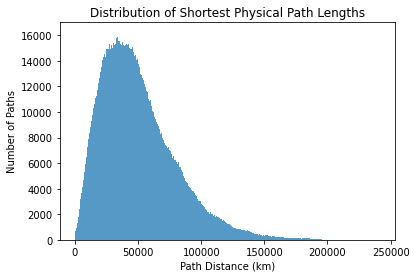

In [38]:
# Shortest physical path length (m)

lengths = nx.shortest_path_length(G, weight='length')
plengths=[]
for key in lengths:   # iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    # saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

sns.histplot(x=plengths, binwidth=5000);
plt.xlabel("Path Distance (m)");
plt.ylabel("Number of Edges");
plt.title("Shortest Path Lengths (m): SoCal Street Network");

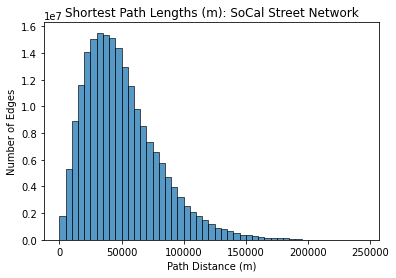

In [45]:
sns.histplot(x=plengths, binwidth=5000);
plt.xlabel("Path Distance (m)");
plt.ylabel("Number of Edges");
plt.title("Shortest Path Lengths (m): SoCal Street Network");

shortest path distribution

In [ ]:
lengths = nx.shortest_path_length(G)
plengths=[]
for key in lengths:   #iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    #saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

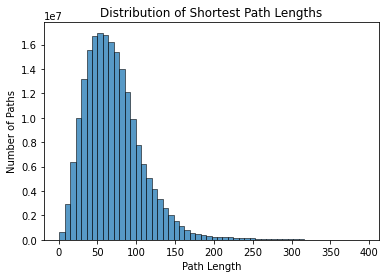

In [51]:
sns.histplot(x=plengths, binwidth=7);
plt.xlabel("Path Length");
plt.ylabel("Number of Paths");
plt.title("Distribution of Shortest Path Lengths");

In [46]:
# G is created as a Multi-DiGraph
# in order to calculate the average clustering, we need to convert it into a DiGraph object

H = nx.DiGraph(G)
H

In [48]:
nx.average_clustering(H)

0.026920664639611288

## Small world?
- we are interested to see if the SoCal EVCS Network resembles a small world network

1. extract network properties

In [53]:
num_nodes = H.number_of_nodes()
num_edges = H.number_of_edges()
c = nx.average_clustering(H)
k = np.mean(list(dict(H.degree()).values()))
l = nx.average_shortest_path_length(H)
n = int(num_nodes)

In [64]:
n, num_edges, k, l

(16753, 26032, 3, 51.61825509263163)

In [60]:
k_int = int(np.mean(list(dict(H.degree()).values())))

2. create a watts strogatz graph with same network property

In [68]:
watts_strogatz_c0 = nx.watts_strogatz_graph(n, k_int, 0)
print("C(0) =" , nx.average_clustering(watts_strogatz_c0))

c_0 = nx.average_clustering(watts_strogatz_c0)+0.001

c_p = nx.average_clustering(H)
p = -(c_p/c_0)**(1/3)+1

print(n, k, p)
watts_strogatz = nx.watts_strogatz_graph(n, k, p, seed=123)

C(0) = 0.0
16753 3 -1.9970587706512823


In [70]:
watts_strogatz = nx.watts_strogatz_graph(n, k, 0.5, seed=123)

In [ ]:
num_nodes_ws = watts_strogatz.number_of_nodes()
num_edges_ws = watts_strogatz.number_of_edges()
c_ws = nx.average_clustering(watts_strogatz)
k_ws = np.mean(list(dict(watts_strogatz.degree()).values()))
l_ws = nx.average_shortest_path_length(watts_strogatz)

In [72]:
socal = ['SoCal Street Network', num_nodes, num_edges, c, k, l]
ws = ['Small World Network Model', num_nodes_ws, num_edges_ws, c_ws, k_ws, l_ws]
df = pd.DataFrame(columns =['network', '#nodes', '#links', '<C>', '<K>', '<L>'])
df.loc[0] = socal
df.loc[1] = ws
df.set_index('network')

,#nodes,#links,<C>,<K>,<L>
network,,,,,
SoCal Street Network,16753,26032,0.026921,3,51.618255
Small World Network Model,16753,16753,0.000000,2.0,192.015645


---

# CA Zipcode Filtering
- for census clustering and LEHD traffic flow analysis

<AxesSubplot:>

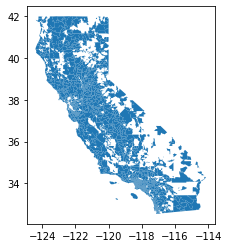

In [452]:
ca_zip = gpd.read_file('data/ca_zipcodes_shapes/tl_2010_06_zcta510.shp')
ca_zip.plot()

<AxesSubplot:>

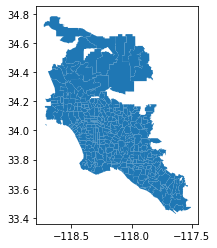

In [453]:
socal_zip = ca_zip.loc[ca_zip.within(poly)]
socal_zip.plot()

change projection to match that of the network

In [454]:
socal_zip_proj = socal_zip.to_crs(G.graph['crs'])

In [472]:
socal_zip.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
54,06,91504,0691504,B5,G6350,S,12783282,29685,+34.2045683,-118.3263651,N,"POLYGON ((-118.34858 34.20846, -118.34856 34.2..."
55,06,91606,0691606,B5,G6350,S,8631179,25464,+34.1857670,-118.3883235,N,"POLYGON ((-118.40307 34.19394, -118.40256 34.1..."
56,06,90640,0690640,B5,G6350,S,21990769,104151,+34.0154437,-118.1110124,N,"POLYGON ((-118.12834 33.98589, -118.12736 33.9..."
57,06,91770,0691770,B5,G6350,S,16634980,138149,+34.0654930,-118.0845292,N,"POLYGON ((-118.10729 34.06622, -118.10732 34.0..."
59,06,90290,0690290,B5,G6350,S,51935407,24096,+34.1077280,-118.6159812,N,"POLYGON ((-118.64064 34.12582, -118.64013 34.1..."


creating a list of zipcodes in the study area 

In [473]:
socal_zip_lst = socal_zip['ZCTA5CE10'].unique().tolist()

In [457]:
# write to file
# socal_zip.to_file("data/ca_zipcodes_shapes/socal_zip.shp")
# socal_zip_proj.to_file("data/ca_zipcodes_shapes/socal_zip_proj.shp")
#socal_zip.to_csv("data/ca_zipcodes_shapes/socal_zip.csv")

---

# EV Registration

In [475]:
ca_veh = pd.read_csv('data/vehicle-count-as-of-1-1-2020.csv')

In [470]:
sum(ca_veh[ca_veh['Make'] == 'TESLA']['Vehicles'])/(sum(ca_veh['Vehicles']))

0.005651370255742801

In [471]:
ca_veh['Fuel'].unique()

array(['Gasoline', 'Natural Gas', 'Diesel and Diesel Hybrid', 'Flex-Fuel',
       'Hybrid Gasoline', 'Other', 'Battery Electric',
       'Hydrogen Fuel Cell', 'Plug-in Hybrid'], dtype=object)

In [474]:
socal_veh = ca_veh[ca_veh['Zip Code'].isin(socal_zip_lst)]
socal_veh.head()

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,1/1/2020,90001,2007,Gasoline,ACURA,Light,15
1,1/1/2020,90002,2007,Gasoline,ACURA,Light,20
2,1/1/2020,90003,2007,Gasoline,ACURA,Light,29
3,1/1/2020,90004,2007,Gasoline,ACURA,Light,19
4,1/1/2020,90006,2007,Gasoline,ACURA,Light,15


ca and socal TESLA vehicle percent share

In [478]:
ca_tsla_pct = sum(ca_veh[ca_veh['Make'] == 'TESLA']['Vehicles'])/(sum(ca_veh['Vehicles']))
socal_tsla_pct = sum(socal_veh[socal_veh['Make'] == 'TESLA']['Vehicles'])/(sum(socal_veh['Vehicles']))

ca_tsla_pct * 100, socal_tsla_pct * 100

(0.5651370255742801, 0.6565636069546463)

EV share piechart

In [481]:
fleet_size = [sum(ca_veh[ca_veh['Fuel'] == fuel]['Vehicles']) for fuel in ca_veh['Fuel'].unique()]
fleet_size

[26985319, 29096, 1271338, 1257292, 1123090, 5867, 306803, 6648, 248388]

In [498]:
type(ca_veh['Model Year'][0])

int

In [509]:
ca_veh['Model Year'].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       '2017', '2018', '2019', '2020', '2021', '<2007', 'Unk'],
      dtype=object)

In [511]:
ca_veh['Model Year > 2007'] = ca_veh['Model Year'].replace('<2007', 0)
ca_veh['Model Year > 2007'] = ca_veh['Model Year > 2007'].replace('Unk', 0)
ca_veh['Model Year > 2007'] = list(map(int, ca_veh['Model Year > 2007']))

ca_veh_2007 = ca_veh[ca_veh['Model Year > 2007'] >= 2007]

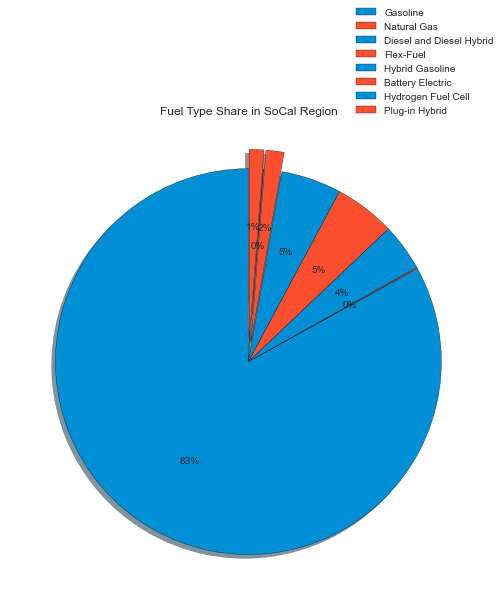

In [515]:
plt.style.use('seaborn')

fig, ax = plt.subplots(nrows=1, ncols=1)

labels = 'Gasoline', 'Natural Gas', 'Diesel and Diesel Hybrid', 'Flex-Fuel', 'Hybrid Gasoline', 'Battery Electric', 'Hydrogen Fuel Cell', 'Plug-in Hybrid'
colors = ['#008fd5', '#fc4f30']
explode = (0, 0, 0, 0, 0, 0.1, 0, 0.1)

plt.title('Fuel Type Share in SoCal Region')
plt.tight_layout()

fleet_size = [sum(ca_veh_2007[ca_veh_2007['Fuel'] == fuel]['Vehicles']) for fuel in labels]


ax.pie(fleet_size, startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=explode, shadow=True)



#fig.suptitle('Public Opinion on CTQ-measures', fontsize=20, y=1.07, fontweight='bold', x=0.37)
fig.set_figheight(10)
fig.set_figwidth(7)
fig.legend(labels=labels, fontsize='medium')
fig.tight_layout()

#fig.savefig('Opinions_ctq')

plt.show()

----

# Network analysis exploration

factors that could correlate more EV charging demand
1. income
2. EV registration
3. population density
4. shortest path distances to the nearest EV charger (the longer the more need for extra charger)
5. 

## Subgraph of EVCS

In [215]:
chargers_socal.head()

,ID,AddressInfo_Postcode,Connections_0_LevelID,DateCreated,geometry
0,139561,90241,2,2019-12-24T09:11:00Z,POINT (-118.13679 33.95245)
1,4841,90241,2,2011-07-04T18:02:00Z,POINT (-118.14548 33.94630)
2,75793,90723,2,2016-12-23T01:25:00Z,POINT (-118.13371 33.94175)
3,121989,90241,2,2019-04-06T05:02:00Z,POINT (-118.15117 33.94730)
4,139551,90241,2,2019-12-24T09:11:00Z,POINT (-118.12922 33.94080)


In [225]:
G_evcs = nx.restricted_view(G, chargers_socal['ID'].tolist())

TypeError: restricted_view() missing 1 required positional argument: 'edges'

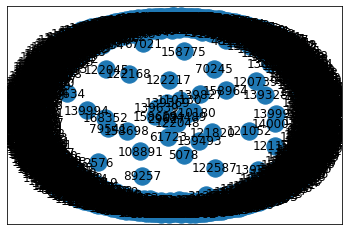

In [222]:
nx.draw_networkx(G_evcs)

In [224]:
list(G_evcs.edges(data=True))

[]

ValueError: Graph has no edges, cannot convert to a GeoDataFrame.

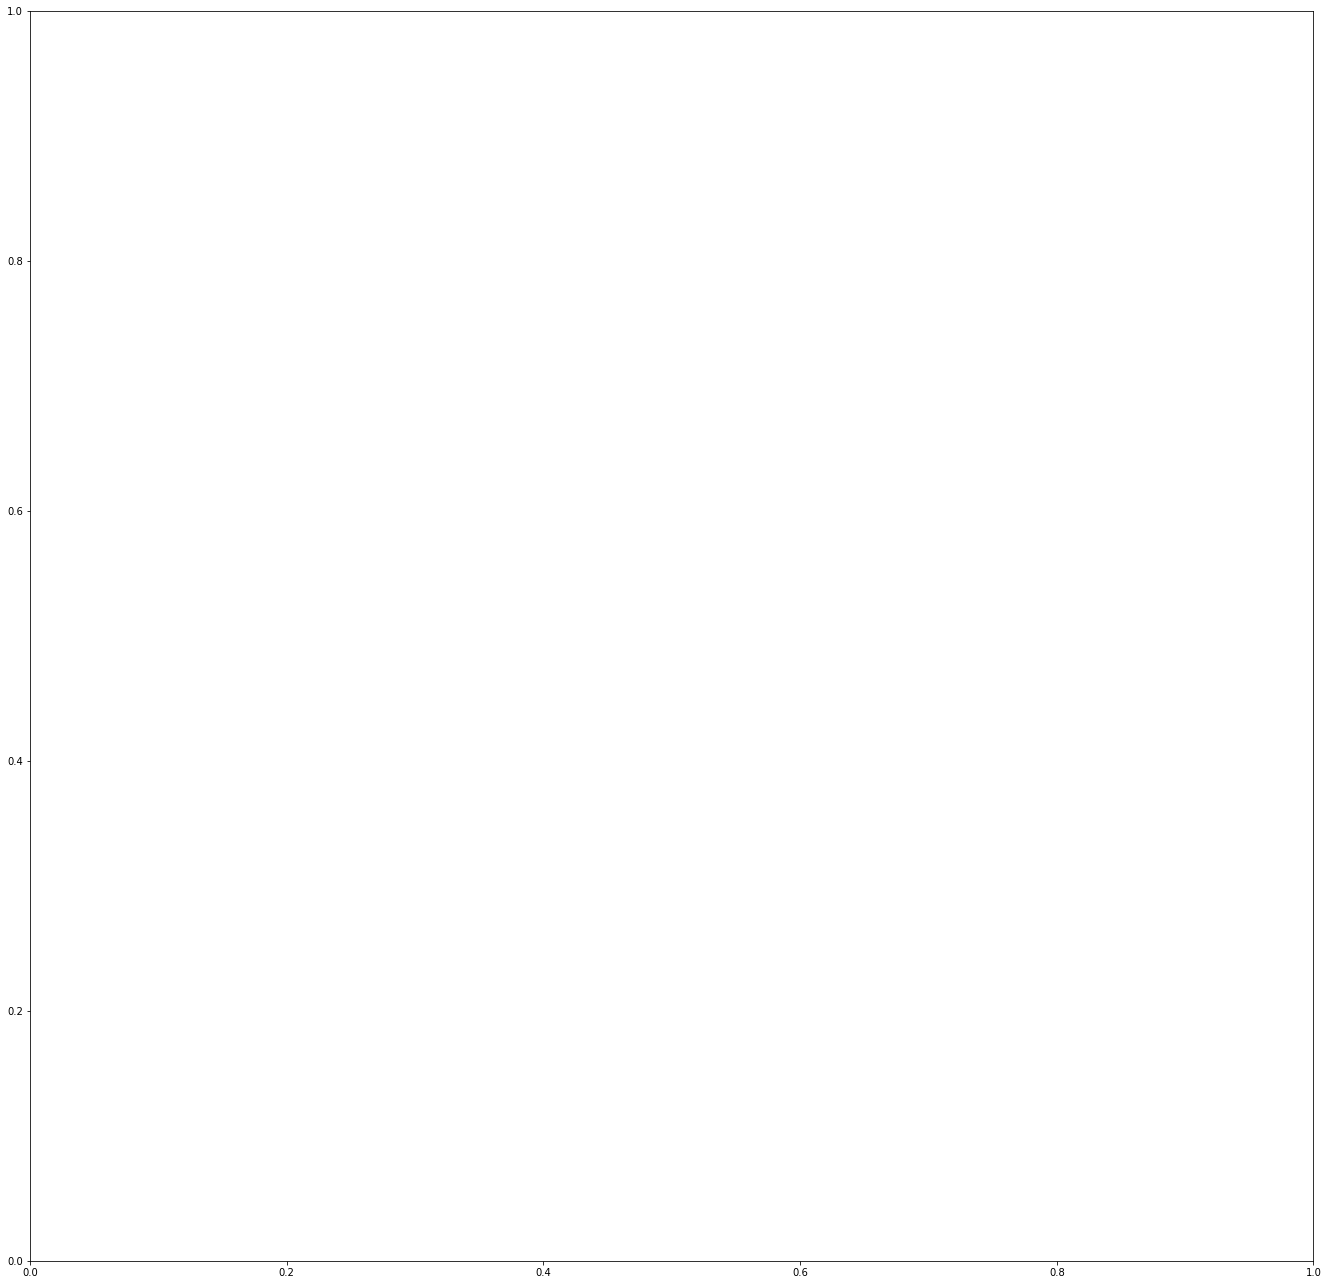

In [217]:
fig, ax = plt.subplots(figsize=(23, 23))

# convert crs to web mercator
chargers_socal_wm = chargers_socal.to_crs(epsg=3857)
G_evcs_wm = ox.project_graph(G_evcs, to_crs='EPSG:3857')

scheme = mc.UserDefined(chargers_socal_wm['Connections_0_LevelID'], bins=[1, 2, 3])


chargers_socal_wm.plot(ax=ax, markersize=0, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLite, zorder=0);
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels, zorder=1);

x, y = poly.exterior.xy
ax.plot(x, y, zorder=10)

geoplot.kdeplot(
      chargers_socal_wm['geometry'], 
      cmap='mako_r', alpha=0.85, shade=True, 
      shade_lowest=False, cbar=False, levels=8, 
      bw_adjust=0.3, 
      ax=ax, zorder=1
);

geoplot.pointplot(
      chargers_socal_wm,
      hue='Connections_0_LevelID', scheme=scheme,
      legend=True,
      ax=ax
);


ox.plot_graph(G_evcs_wm, ax=ax, edge_color="grey", node_size=0);

plt.savefig('/Users/jarvis/Desktop/CE 88/SoCalEVCSNetwork//plot/SoCalEVCS_kde_basemap.png', dpi=300)